In [252]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import seaborn as sns
import sklearn
import warnings
import miceforest as mf
import xgboost as xgb
import lightgbm as lgb
import shap

from joblib import dump, load
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.cluster import KMeans

from sklearn.exceptions import DataConversionWarning, FitFailedWarning, ConvergenceWarning

In [253]:
path = 'data/quake.csv'


data = pd.read_csv(path,sep=',')
data.drop_duplicates(inplace=True)
data.head()

,Focal depth,Latitude,Longitude,Richter
0,33,-52.26,28.30,6.7
1,36,45.53,150.93,5.8
2,57,41.85,142.78,5.8
3,67,29.19,141.15,6.2
4,30,-21.66,169.81,6.0


In [254]:
missing_percentage = (data.isnull().sum() / len(data)) * 100
print(missing_percentage)

Focal depth    0.0
Latitude       0.0
Longitude      0.0
Richter        0.0
dtype: float64


Nice, there is no missing data. Lets plot the geographic positions of quakes as well as their magnitudes.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<Axes: xlabel='Longitude', ylabel='Latitude'>

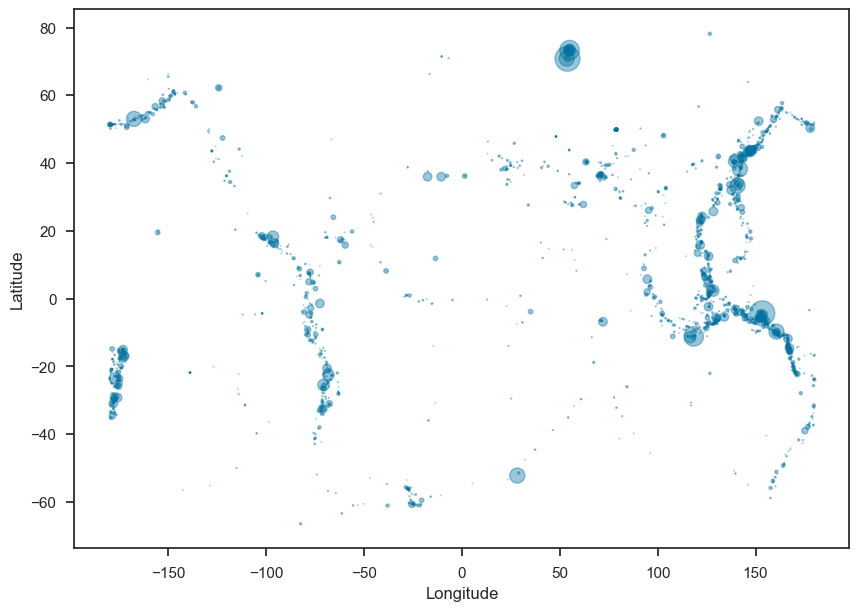

In [255]:
data.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
    s=(data["Richter"]-5)**9, figsize=(10,7),  
)

#c="Richter", cmap=plt.get_cmap("jet"), colorbar=True,

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<Axes: xlabel='Longitude', ylabel='Latitude'>

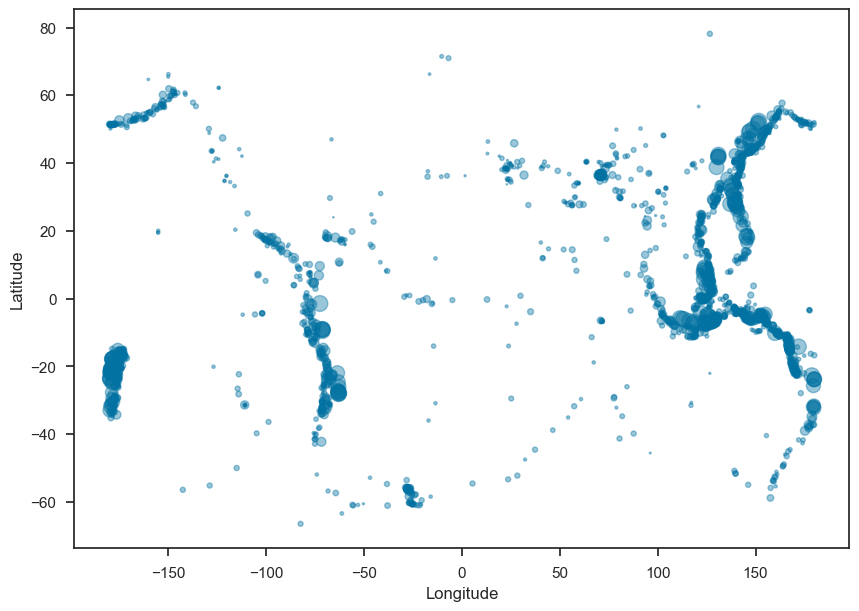

In [256]:
data.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
    s=data["Focal depth"]**(3/4), figsize=(10,7),  
)

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


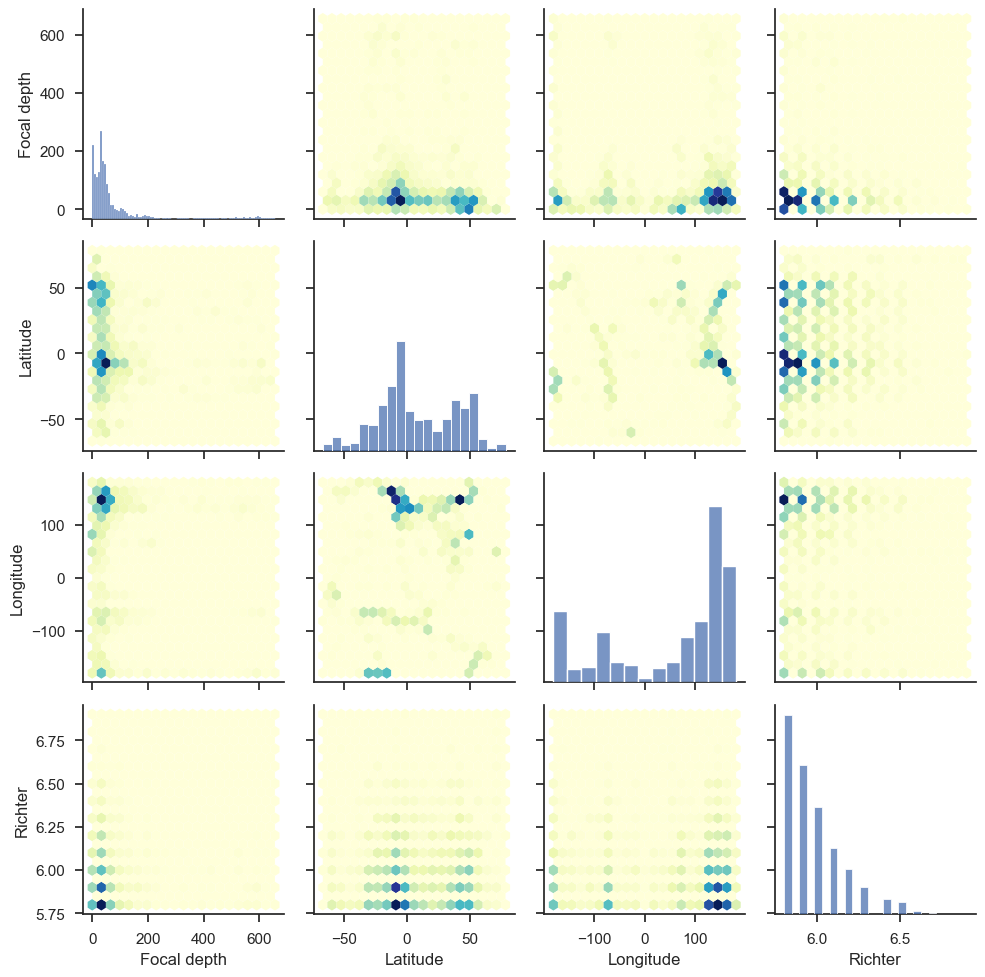

In [257]:
sns.set(style="ticks")
g = sns.PairGrid(data)
g.map_diag(sns.histplot)
g.map_offdiag(lambda *args, **kwargs: plt.hexbin(*args, gridsize=20, cmap='YlGnBu', edgecolors='none'))

plt.show()

We can definitely see that some areas have much bigger frequency of earthquakes than others.

[[ 1.   -0.13 -0.02 -0.01]
 [-0.13  1.    0.14  0.07]
 [-0.02  0.14  1.   -0.02]
 [-0.01  0.07 -0.02  1.  ]]


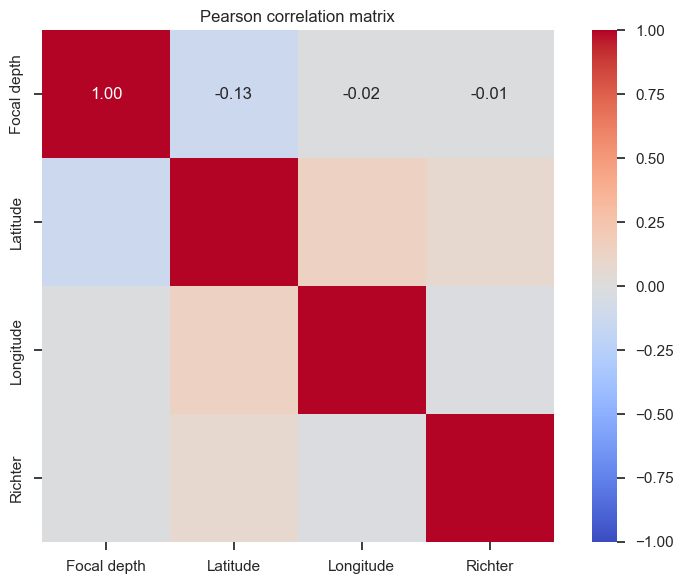

In [258]:
plt.figure(figsize=(8, 6))
cor = data.corr()
sns.heatmap(cor, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f",annot=True, square=True)
plt.title("Pearson correlation matrix")
plt.tight_layout()
#plt.show()
print(np.round(cor.to_numpy(), 2))


Now we need to scale the features.

In [259]:
data['Longitude'].max(), data['Longitude'].min()

(180.0, -179.96)

In [260]:
original_data = data.copy()

scaler = StandardScaler()
data[['Richter', 'Focal depth']] = scaler.fit_transform(data[['Richter', 'Focal depth']])

# Normalize longitude and latitude using MinMaxScaler
latlong_scaler = MinMaxScaler()
data[['Longitude', 'Latitude']] = latlong_scaler.fit_transform(data[['Longitude', 'Latitude']])

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


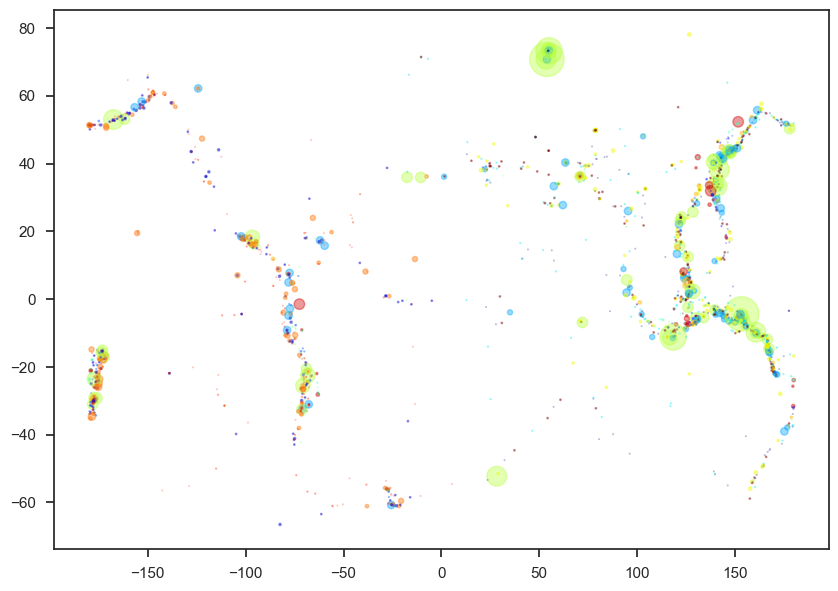

In [261]:
#kmeans = KMeans(n_clusters=15)
#kmeans.fit(data)

data['cluster'] = KMeans(n_clusters=15).fit_predict(data)

fig, ax = plt.subplots(figsize=(10, 7))


# Scatter plot over the image
scatter = ax.scatter(original_data["Longitude"], original_data["Latitude"], alpha=0.4,
                     s=(original_data["Richter"] - 5) ** 10, c=data["cluster"],
                     cmap=plt.get_cmap("jet"))

plt.show()

Obtained clustering seems to be pretty random. Lets try to use some methods in order to estabilish best number of clusters.

## Elbow method

This method is based on calculating Within-Cluster-Sum of Squared Errors (WSS) for different number of clusters (k) and selecting the k for which change in WSS first starts to diminish. This approach comes from the fact that with the growth of number of clusters explained variation of data can increase rapidly for a small k but at some point the change really slows down. We want to find that 'elbow' point that has the biggest explained variation while keeping number of clusters relatively small.

In [262]:
def spherical_longitude_distance(lon1, lon2):
    diff = np.abs(lon1 - lon2)
    if diff > 0.5:
        diff = 1 - diff
    return diff

def custom_distance(X, Y):
    distance = np.zeros((X.shape[0], Y.shape[0]))
    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            # Calculate distance based on feature types
            distance_i_j = 0.0
            for f in range(X.shape[1]):
                # For longitude, use spherical distance
                if f == 1:
                    distance_i_j += (spherical_longitude_distance(X[i, f], Y[j, f]))**2
                else:
                    # For other features, use Euclidean distance
                    distance_i_j += (X[i, f] - Y[j, f])**2
            distance[i, j] = np.sqrt(distance_i_j)
    return distance

Since longitude is periodical feature, the distance for example between -180 and 180 should be 0. However it seems that i cant set my custom metric for Kmeans so I will just leave it as it is.

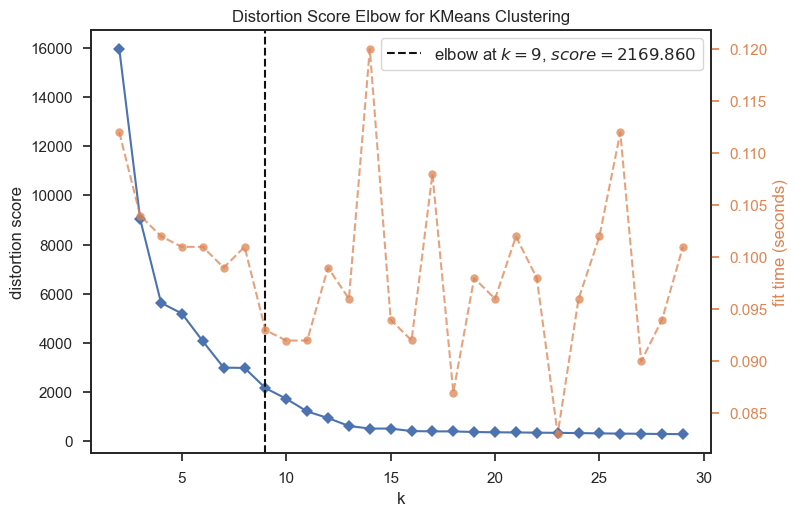

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [263]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(n_init='auto')

visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(data)        
visualizer.show()        

So elbow method is saying that the optimal number of clusters is 9. Lets visualize them on a world map.

In [264]:
ground_truth = KMeans(n_clusters=9).fit_predict(data)
data['cluster'] = ground_truth

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


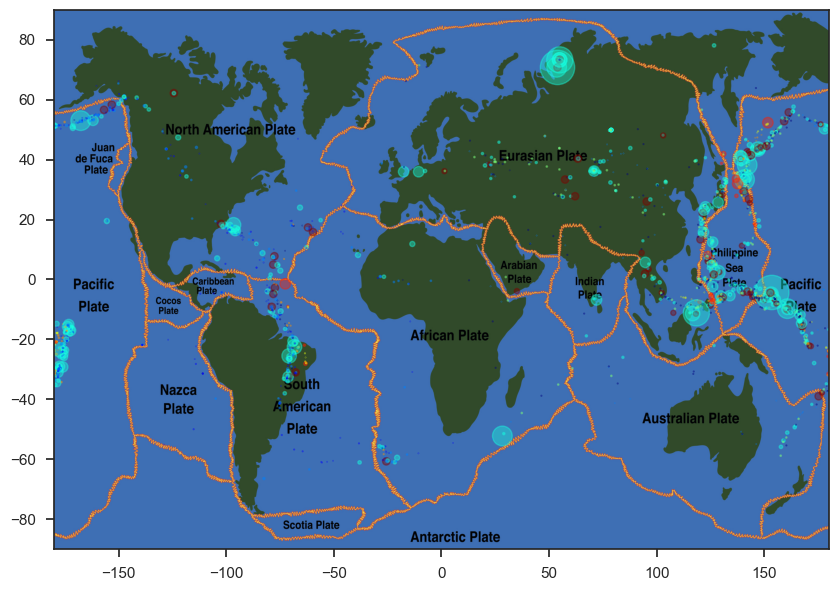

In [265]:
img = plt.imread('tectonic.jpg') 
fig, ax = plt.subplots(figsize=(10, 7))

# Set the image as the background
ax.imshow(img, extent=[-180, 180, -90, 90], aspect='auto')

# Scatter plot over the image
scatter = ax.scatter(original_data["Longitude"], original_data["Latitude"], alpha=0.4,
                     s=(original_data["Richter"] - 5) ** 10, c=data["cluster"],
                     cmap=plt.get_cmap("jet"))

plt.show()


This map doesnt necessarily fit perfectly our data, nevertheless we can certainly see some patterns. Earthquakes tend to occur in proximity to edges of tectonic plates or points where land meets the sea. Algorithm grouped together earthquakes with similar magnitutes.

In [266]:
data.drop(columns=['cluster'], inplace=True)

Okay. We see now that the division of data into clusters is strongly correlated to their geographic position. 

## Silhouette coefficient

It is a simple approach based on a formula: $$s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}$$

 - $s(i)$ is the silhouette coefficient for point i
 - $a(i)$ is the average distance from i to other points in the same cluster as i
 - $b(i)$ is the smallest average distance from i to points in a different cluster, minimized over clusters

Silhouette coefficient for dataset is just an average of silhouette coefficients for all its points. If the Silhouette coefficient is:

 - close to 0 means that the point is between two clusters
 - closer to -1, then we would be better off assigning it to the other clusters
 - close to 1, then the point belongs to the ‘correct’ cluster

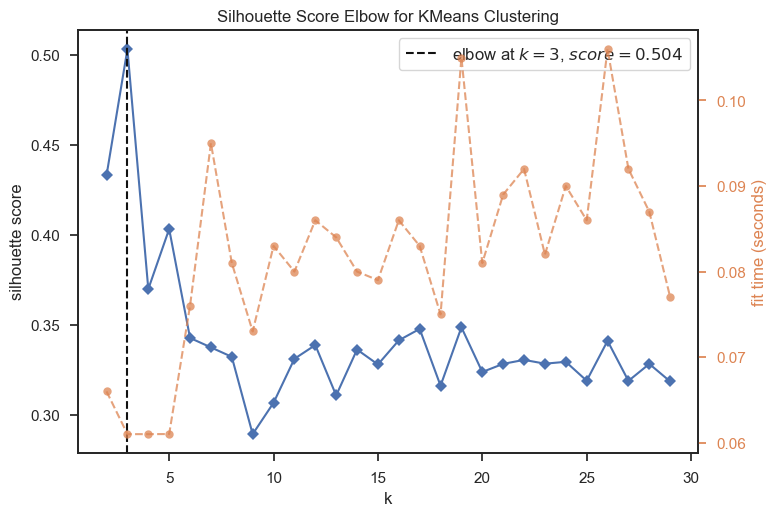

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [267]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(data)        # Fit the data to the visualizer
visualizer.show()  

This method revealed that the optimal number of clusters is 3.

In [268]:
data['cluster'] = KMeans(n_clusters=3).fit_predict(data)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


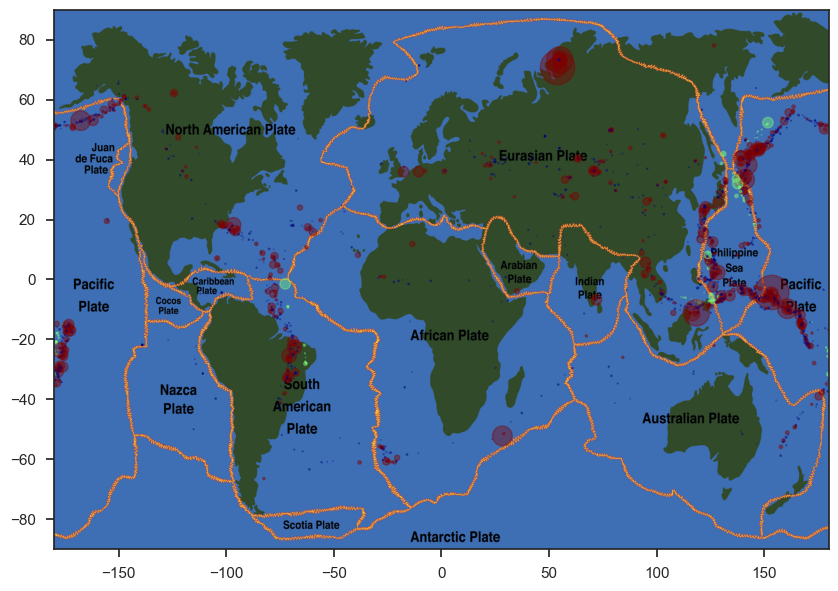

In [269]:
img = plt.imread('tectonic.jpg') 
fig, ax = plt.subplots(figsize=(10, 7))

# Set the image as the background
ax.imshow(img, extent=[-180, 180, -90, 90], aspect='auto')

# Scatter plot over the image
scatter = ax.scatter(original_data["Longitude"], original_data["Latitude"], alpha=0.4,
                     s=(original_data["Richter"] - 5) ** 10, c=data["cluster"],
                     cmap=plt.get_cmap("jet"))

plt.show()


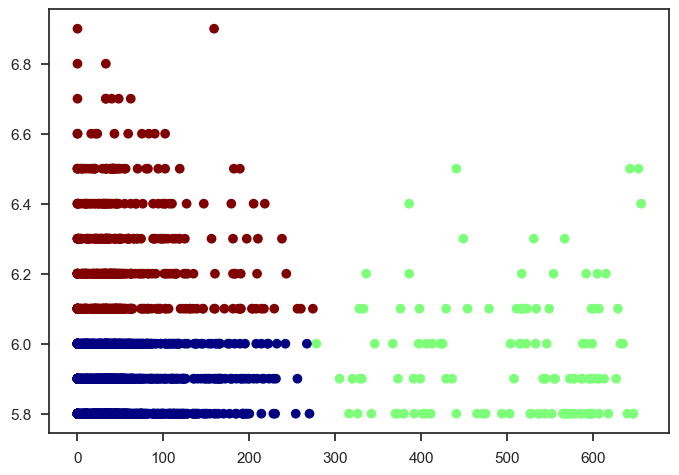

In [270]:
plt.scatter(original_data['Focal depth'],original_data['Richter'],c=data['cluster'], cmap=plt.get_cmap("jet"))
plt.show()

Well here we can see that clusters are clearly separated based on the Focal Depth of the earthquake. 

In [271]:
data.drop(columns=['cluster'], inplace=True)

### Minibatch kmeans

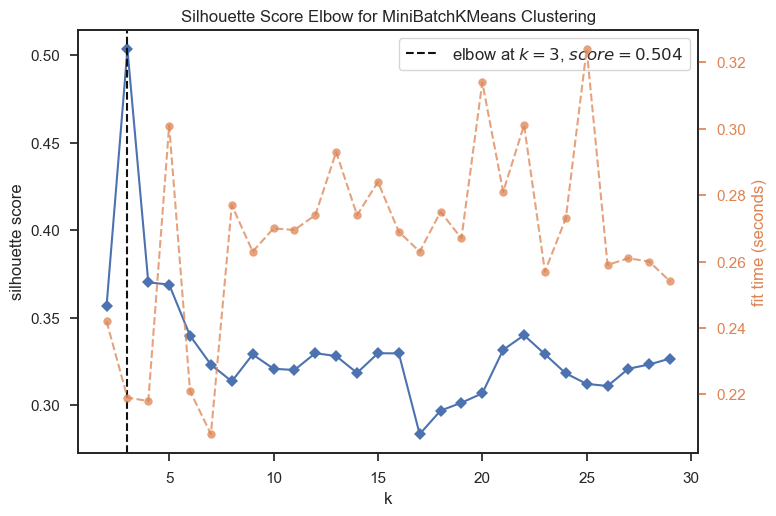

<Axes: title={'center': 'Silhouette Score Elbow for MiniBatchKMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [272]:
from sklearn.cluster import MiniBatchKMeans

model = MiniBatchKMeans(random_state=42, n_init='auto') 
visualizer = KElbowVisualizer(model, k=(2,30), metric='silhouette', timings= True)
visualizer.fit(data)   
visualizer.show()  

In [273]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=3, random_state=42, n_init=3)

minibatch_kmeans.fit(data)

cluster_labels = minibatch_kmeans.labels_
data['cluster'] = pd.Series(cluster_labels)

centroids = minibatch_kmeans.cluster_centers_

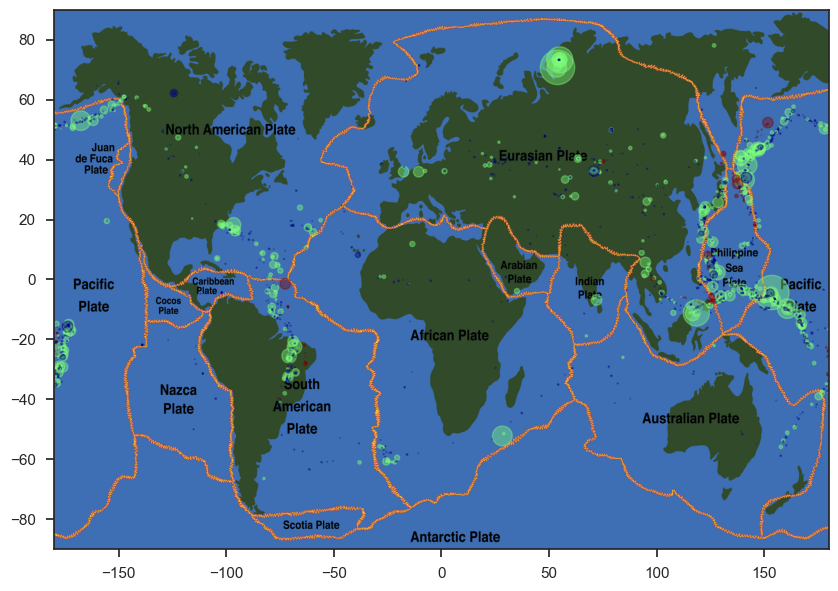

In [274]:
img = plt.imread('tectonic.jpg') 
fig, ax = plt.subplots(figsize=(10, 7))

# Set the image as the background
ax.imshow(img, extent=[-180, 180, -90, 90], aspect='auto')

# Scatter plot over the image
scatter = ax.scatter(original_data["Longitude"], original_data["Latitude"], alpha=0.4,
                     s=(original_data["Richter"] - 5) ** 10, c=data["cluster"],
                     cmap=plt.get_cmap("jet"))

plt.show()

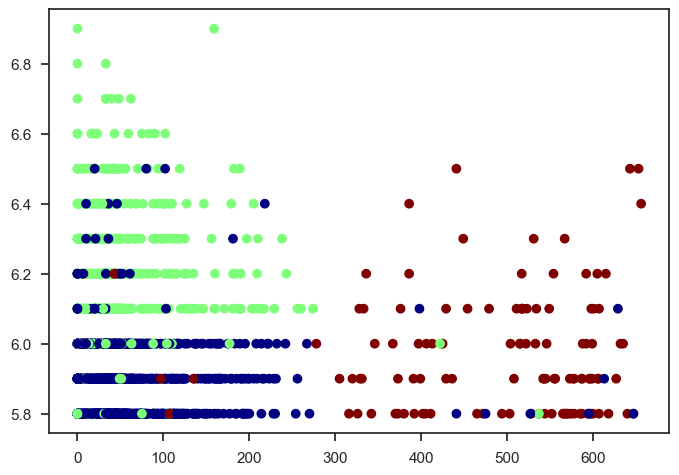

In [275]:
plt.scatter(original_data['Focal depth'],original_data['Richter'],c=data['cluster'], cmap=plt.get_cmap("jet"))
plt.show()

In [276]:
data.drop(columns=['cluster'], inplace=True)

Minibatch implementation tends to reach suboptimal solutions because of operating only on random subsets of the data. Produced clusters can be lass accurate and not bring as much information about structure of data. However because of those randomness it might escape local minima easier. It is also faster what can be huge advantage when dealing with bigger datasets.

Here we can see that the solution of minibatch kmeans reached slightly worse separation of clusters than algorithm trained on full data.

## OTHER CLUSTERING ALGORITHMS

### DBSCAN

Another algorithm we are going to try is Density-based spatial clustering of applications with noise. First step of this algorithm is assigning each point a label (using two parameters $\epsilon$ and MinPoint and of course we need some metric in order to measure distance between points):
 - core, if there is at least MinPoint points that are no farther from point than $\epsilon$ (neighbors)
 - border, if the number of neighbors is less than MinPoint but bigger than 0
 - outlier if it has no neighbors

Then it iterates over core points and cluster them with their neighbors and if some of neighbors are also core points it searches also for their neighbors

Parameters:  {'eps': 0.05, 'min_samples': 2}  Score:  0.40793310675780686
Parameters:  {'eps': 0.05, 'min_samples': 3}  Score:  0.37315629521744453
Parameters:  {'eps': 0.05, 'min_samples': 4}  Score:  0.42002938160845793
Parameters:  {'eps': 0.05, 'min_samples': 5}  Score:  0.40608833993668814
Parameters:  {'eps': 0.05, 'min_samples': 6}  Score:  0.5010156816220115
Parameters:  {'eps': 0.05, 'min_samples': 7}  Score:  0.5037393979461804
Parameters:  {'eps': 0.05, 'min_samples': 8}  Score:  0.5101910176718023
Parameters:  {'eps': 0.05, 'min_samples': 9}  Score:  0.5679477391428126
Parameters:  {'eps': 0.05, 'min_samples': 10}  Score:  0.6146260173472016
Parameters:  {'eps': 0.1, 'min_samples': 2}  Score:  0.1645164644330636
Parameters:  {'eps': 0.1, 'min_samples': 3}  Score:  0.25012666756959023
Parameters:  {'eps': 0.1, 'min_samples': 4}  Score:  0.2816402048485859
Parameters:  {'eps': 0.1, 'min_samples': 5}  Score:  0.3098652760767
Parameters:  {'eps': 0.1, 'min_samples': 6}  Score: 

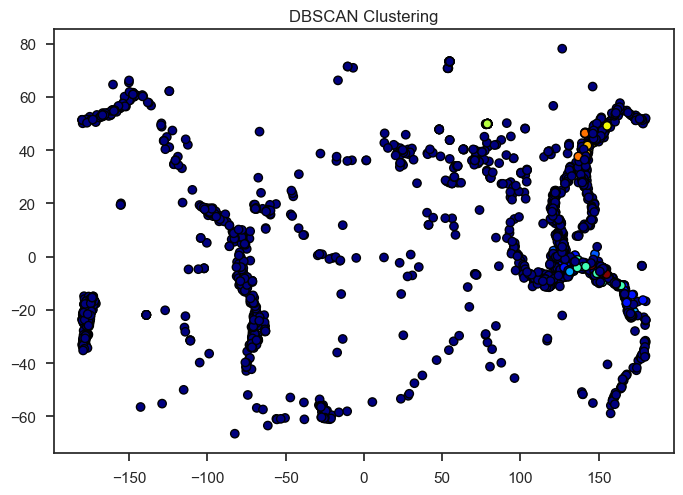

In [277]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import ParameterGrid, KFold

param_grid = {'eps': np.linspace(5e-2, 5e-1, 10, True),
              'min_samples': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

best_score = -1
best_params = {}

for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(**params)
    labels = dbscan.fit_predict(data)
    
    # Evaluate silhouette score on the entire dataset
    if len(np.unique(labels)) > 2:  # At least two clusters should exist
        indexes_not_minus_1 = np.where(labels != -1)[0]
        score = silhouette_score(data.iloc[indexes_not_minus_1], labels[indexes_not_minus_1])
        #score = calinski_harabasz_score(data.iloc[indexes_not_minus_1], labels[indexes_not_minus_1])
        if score > best_score:
            best_score = score
            best_params = params
        print('Parameters: ', params, ' Score: ', score )

print("Best Parameters:", best_params)
print("Best Score:", best_score)

best_dbscan = DBSCAN(**best_params)

# Fit DBSCAN on your entire dataset
labels = best_dbscan.fit_predict(data)

# Visualizing the clusters
plt.scatter(original_data["Longitude"], original_data["Latitude"], c=labels, cmap=plt.get_cmap("jet"), edgecolors='black') #plt.get_cmap("jet") , marker='o'
plt.title('DBSCAN Clustering')
plt.show()

It seems that DBSCAN has a problem finding meaningful clusters in our data. Lets try to fix the number of clusters. We will evaluate performance for each set of parameters using labels obtained with KMeans for 9 clusters and adjusted random score, which measures the similarity between two clusterings, considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true labelings.

Parameters:  {'eps': 0.3452631578947368, 'min_samples': 10}  Score:  0.421043366742181
Best Parameters: {'eps': 0.3452631578947368, 'min_samples': 10}
Best Score: 0.421043366742181


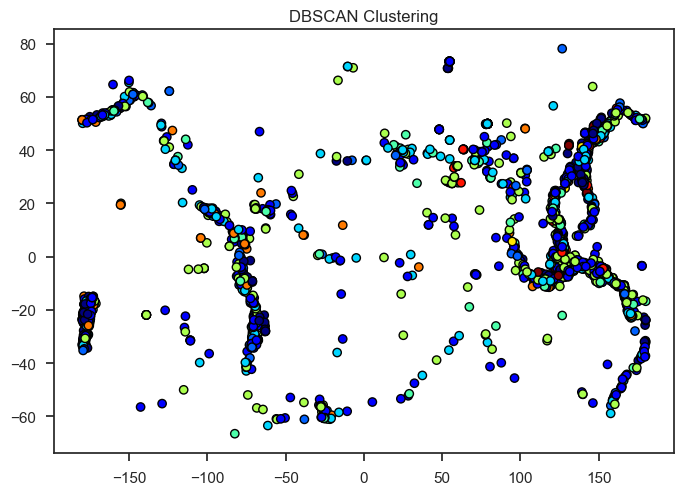

In [280]:
from sklearn.metrics import adjusted_rand_score

param_grid = {'eps': np.linspace(1e-2, 5e-1, 20, True),
              'min_samples': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

best_score = -1
best_params = {}

for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(**params)
    labels = dbscan.fit_predict(data)
    
    indexes_not_minus_1 = np.where(labels != -1)[0]
    if len(np.unique(labels[indexes_not_minus_1])) == 9:  # At least two clusters should exist
        
        score = adjusted_rand_score(ground_truth[indexes_not_minus_1], labels[indexes_not_minus_1])
        #score = calinski_harabasz_score(data.iloc[indexes_not_minus_1], labels[indexes_not_minus_1])
        if score > best_score:
            best_score = score
            best_params = params
        print('Parameters: ', params, ' Score: ', score )

print("Best Parameters:", best_params)
print("Best Score:", best_score)

best_dbscan = DBSCAN(**best_params)

# Fit DBSCAN on your entire dataset
labels = best_dbscan.fit_predict(data)

# Visualizing the clusters
plt.scatter(original_data["Longitude"], original_data["Latitude"], c=labels, cmap=plt.get_cmap("jet"), edgecolors='black') #plt.get_cmap("jet") , marker='o'
plt.title('DBSCAN Clustering')
plt.show()

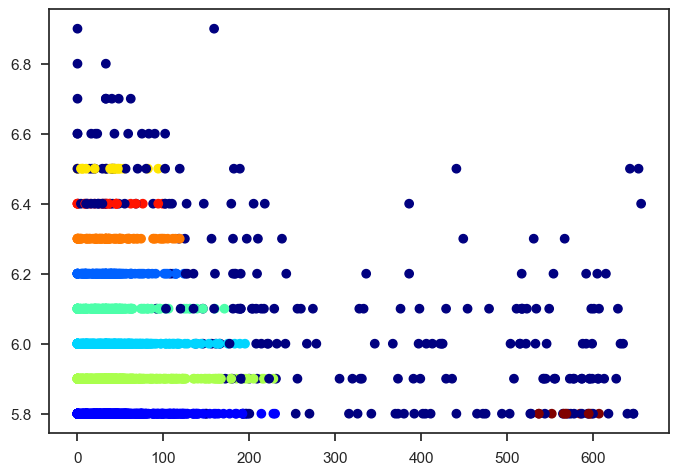

In [281]:
plt.scatter(original_data['Focal depth'],original_data['Richter'],c=labels, cmap=plt.get_cmap("jet"))
plt.show()

It seems that DBSCAN is not able to find some meaningful clusters in our case. This might be the case, because opposed to kmeans it is a density-based algorithm. It behaves poorly when density of clusters varies. Moreover, as we already estabilished, we ae dealing with data stretched along the edges of tectonic plates - such elongated data is not a good input for DBSCAN. It reached very low similarity to KMeans clusters.

When forced to come up with estabilished in kmeans optimal number of clusters - 9 it reached some solution, clearly based on focal depth and magnitude. However in geographical coordinates of clusters its hard to find patterns.

Lets try another algorithm.

### Hierarchical Agglomerative Clustering

Hierarchical Agglomerative Clustering (HAC) is a bottom-up approach to clustering that progressively merges individual data points or clusters into larger clusters. Starting with each data point as its own cluster, HAC iteratively combines the closest pair of clusters based on a chosen linkage criterion (e.g., Ward, complete, average) until all points belong to a single cluster or a stopping criterion, such as the number of clusters or a defined distance threshold, is met. The process creates a hierarchy of clusters, visualized as a dendrogram, allowing users to explore clustering solutions at different granularities. HAC is flexible in handling various data shapes and cluster structures and does not require specifying the number of clusters beforehand.

In [282]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

agg_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
clusters = agg_clustering.fit_predict(data)

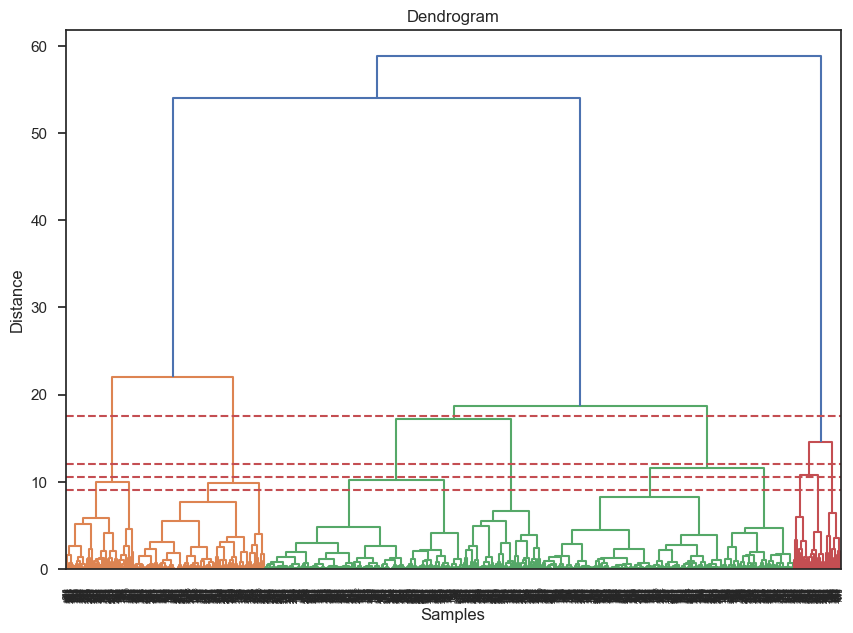

In [284]:
linked = linkage(data, method='ward') 
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.axhline(y=17.5, color='r', linestyle='--')
plt.axhline(y=12, color='r', linestyle='--')
plt.axhline(y=10.5, color='r', linestyle='--')
plt.axhline(y=9, color='r', linestyle='--')
plt.show()

We want to obtain 9 clusters in order to compare this method with kmeans. This means distance threshold around 10.5 .

Parameters: {'linkage': 'ward', 'n_clusters': 9} Silhouette Score: 0.3146024628928572  Similarity to KMeans:  0.4743862088903727
Parameters: {'linkage': 'complete', 'n_clusters': 9} Silhouette Score: 0.322485737832567  Similarity to KMeans:  0.20203490130563403
Parameters: {'linkage': 'average', 'n_clusters': 9} Silhouette Score: 0.4479133930162354  Similarity to KMeans:  0.11335332880162872
Parameters: {'linkage': 'single', 'n_clusters': 9} Silhouette Score: 0.4207701760710219  Similarity to KMeans:  0.0025147895847879667
Best Parameters: {'linkage': 'ward', 'n_clusters': 9}
Best Score: 0.4743862088903727
Silhouette Score:  0.3146024628928572


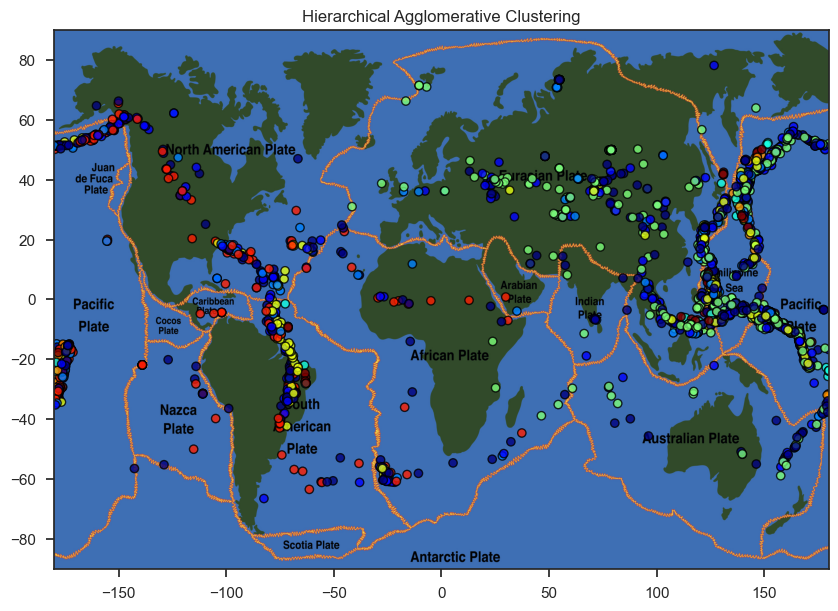

In [308]:
agg_clustering = AgglomerativeClustering(n_clusters=9)

param_grid = {
    'n_clusters': [9],
    'linkage': ['ward', 'complete', 'average', 'single']
}

best_score = -1
best_params = {}

for params in ParameterGrid(param_grid):
    # Create AgglomerativeClustering model
    agg_clustering = AgglomerativeClustering(**params)
    
    # Fit the model
    labels = agg_clustering.fit_predict(data)
    
    rand_score = adjusted_rand_score(ground_truth, labels)
    sil_score = silhouette_score(data, labels)
    if rand_score > best_score:
        best_score = rand_score
        best_sil = sil_score
        best_params = params
    print('Parameters:', params, 'Silhouette Score:', sil_score, ' Similarity to KMeans: ', rand_score)

print("Best Parameters:", best_params)
print("Best Score:", best_score)
print('Silhouette Score: ', best_sil)
best_model = AgglomerativeClustering(**best_params)
labels = best_model.fit_predict(data)

img = plt.imread('tectonic.jpg') 
fig, ax = plt.subplots(figsize=(10, 7))

# Set the image as the background
ax.imshow(img, extent=[-180, 180, -90, 90], aspect='auto')

ax.scatter(original_data["Longitude"], original_data["Latitude"], c=labels, cmap=plt.get_cmap("jet"), edgecolors='black',alpha=0.8)
#s=(original_data["Richter"]-5)**11)
ax.set_title('Hierarchical Agglomerative Clustering')
plt.show()

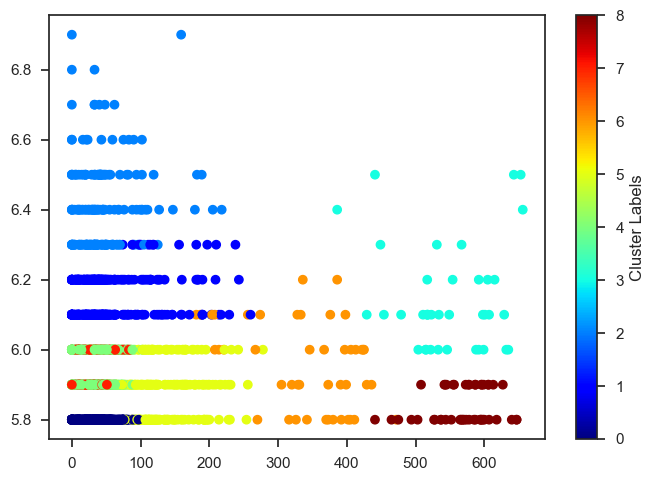

In [312]:
scatter = plt.scatter(original_data['Focal depth'],original_data['Richter'],c=labels, cmap=plt.get_cmap("jet"))
plt.colorbar(scatter, label='Cluster Labels')
plt.show()

We can definitely see some arrangement in geographical positions of clusters as well as in the plot of Focal Deepth vs Richter. Agglomerative clustering didnt reach very similar results to KMeans (below 0.5 adjusted rand score) but it seems to have done a good job. Clusters are mostly well separated. especially in depth and magnitude dimensions.

Lets plot each cluster separately on a world map.

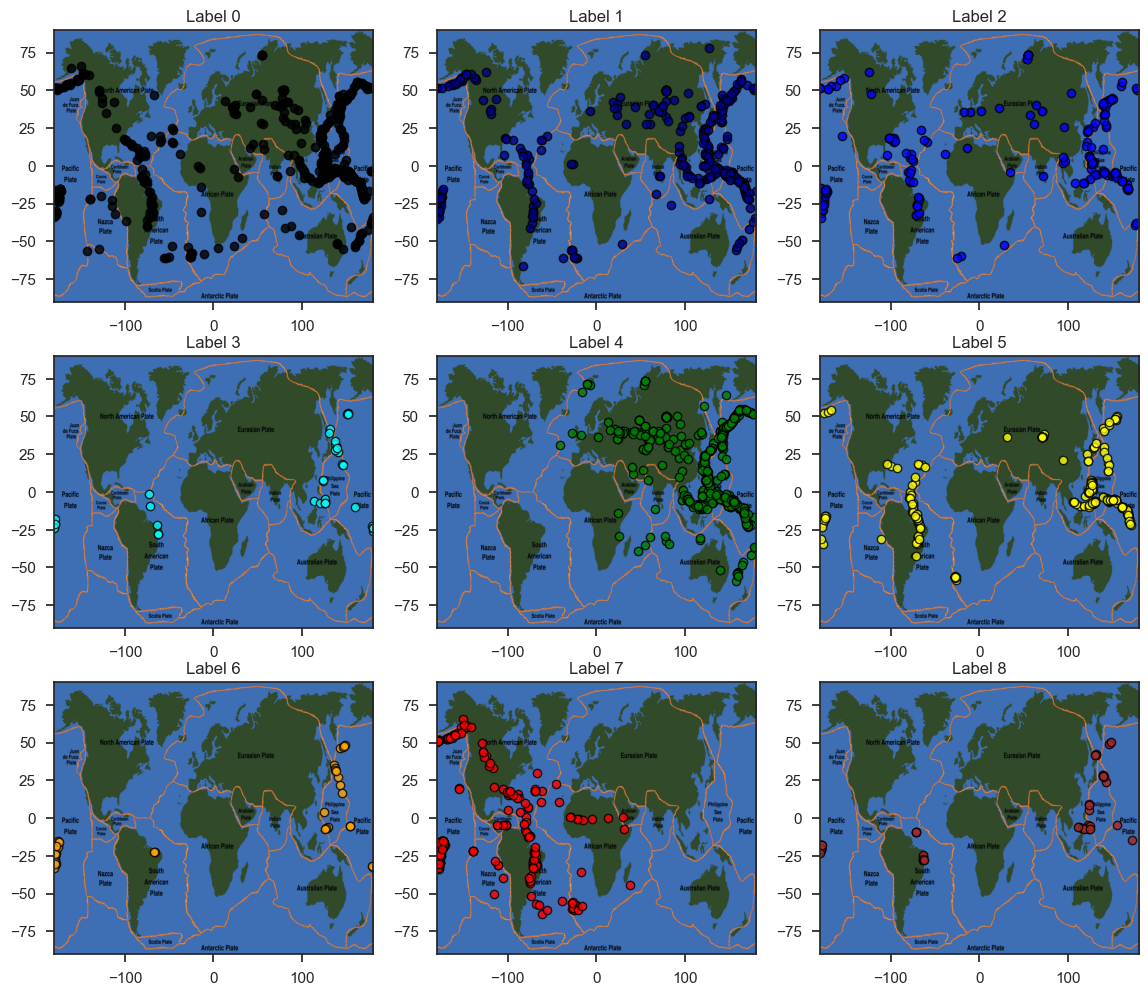

In [315]:
img = plt.imread('tectonic.jpg') 
fig, ax = plt.subplots(3,3,figsize=(14, 12))

# Set the image as the background

colors = ['black', 'darkblue', 'blue', 'cyan', 'green', 'yellow', 'orange', 'red', 'brown']

for i in range(9):
    points_label = original_data[labels == i]

    row = i // 3
    col = i % 3

    # Plot only points with label
    ax[row,col].imshow(img, extent=[-180, 180, -90, 90], aspect='auto')
    ax[row,col].scatter(points_label["Longitude"], points_label["Latitude"], c=colors[i], edgecolors='black', alpha=0.8)
    ax[row,col].set_title(f'Label {i}')

plt.show()

Intepretation of clusters:
 - Black - present in most parts of the world, low magnitudes and depths
 - Dark Blue - present in most parts of the world, medium magnitudes and low depths
 - Blue - present in most parts of the world, very high magnitudes and low depths
 - Cyan - present out of continents, near Philipines, Japan and northern part of South America, medium magnitudes, high depths
 - Green - present mostly in Eurasian continent mass and western part of Pacific, low depths and magnitudes
 - Yellow - present in similar regions as cyan but has low magnitudes and medium depths
 - Orange - similar to yellow but higher depths
 - Red - present in both Americas, Atlantic Ocean and Africa, low magnitudes and depths
 - Brown - once again similar regions to cyan, also similar depths but much lower magnitudes
 

Obtained clusters helped with interpretation of our data. They revealed patterns and dependencies between earthquake parameters and its geographical position. Aggregative Clustering Algorithm reached very satisfying results which can make sense. From the three used algorithms it probably performed the best. However if the data was bigger it could affect its computational costs. KMeans also achieved sensible solutions. 
DBSCAN seemed to be the worst choice for our task because of elongated shapes of clusters and variations in density.